In [4]:
from torch.utils.data import Dataset
from PIL import Image
import scipy.io
import os
import csv
import random
import cv2

In [5]:

class CELEBADriver:
    
    #['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y','leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']
    #['000001.jpg', '69', '109', '106', '113', '77', '142', '73', '152', '108', '154']
    #['image_id', 'x_1', 'y_1', 'width', 'height']
    #['000001.jpg', '95', '71', '226', '313']

    def __init__(self, bbox_path, landmarks_path, imgs_path):
        self.bbox_path = bbox_path
        self.landmarks_path = landmarks_path
        self.imgs_path = imgs_path
        self.data = {}
        self.dataset_index = []  # 样本汇总
        self.init_dataset()

    def init_dataset(self):
        with open(self.bbox_path, mode='r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            count = 0
            for row in csv_reader:
                if count == 0:
                    count += 1
                    continue
                self.data[count] = {"name":row[0]}
                self.data[count]["bbox"] = [int(x) for x in row[1:]]
                count += 1
                
        with open(self.landmarks_path, mode='r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            count = 0
            for row in csv_reader:
                if count == 0:
                    count += 1
                    continue
                self.data[count]["ldmk"] = [int(x) for x in row[1:]]
                count += 1

        self.dataset_index = [x for x in range(count)]

    def get_file_path(self, index):
        # index 获取一个图片文件路径
        return self.imgs_path + "\\" + self.data[index]["name"]

    def get_face_bbx_list(self, index):
        return [self.data[index]["bbox"]]

    def get_face_ldmk_list(self, index):
        return [self.data[index]["ldmk"]]

    def random_init(self):
        random.shuffle(self.dataset_index)

    def get_data(self, i):
        i = self.dataset_index[i]
        return (self.get_file_path(i),self.get_face_bbx_list(i),self.get_face_ldmk_list(i))

class WFDriver:

    def __init__(self, mat_path, clas_root_path):
        self.data = scipy.io.loadmat(mat_path) # 读取 mat 文件到 内存中
        self.r_path = clas_root_path # 类别文件 系统根目录
        self.clas_i_map = {} # 我们利用文件命名中的数字编号 作为索引
        # 建立clas_i_map 将文件命名中的编号 和 mat数据中索引进行关联
        self.clas_map = {} # 将 文件命名中的编号 和 类别文件夹的全名
        self.dataset_index = [] # 样本汇总

        self.init_clas_map() 
        
    def init_clas_map(self):
        # 初始化 类别标签
        # 我们利用文件命名中的数组编号 作为索引
        # 建立clas_i_map 将文件命名中的编号 和 数据中随机索引进行关联
        for i in range(len(self.data["file_list"])):
            j = int(self.data["file_list"][i][0][0][0][0].split("_")[0])
            self.clas_i_map[j] = i

        # 生成clas_map，将类别编号 和其 名称绑定
        for _, dirs, files in os.walk(self.r_path):
            for dir in dirs:

                clas_i = int(dir.split("--")[0]) # 根据目录名字 生成类别索引
                self.clas_map[clas_i] = dir      # 将类别索引 与 目录名字 建立连接

                num_smp = len(self.data["file_list"][self.clas_i_map[clas_i]][0]) # 求出一个类别有多少个样本
                self.dataset_index += [(clas_i, x) for x in range(num_smp)] # 并入 样本数组

            
    def get_file_path(self, clas, index):
        # 通过 clas 和 index 获取一个图片文件信息
        return self.r_path + "\\" + self.clas_map[clas]\
                + "\\" + self.data["file_list"][self.clas_i_map[clas]][0][index][0][0] + ".jpg"

    def get_face_bbx_list(self, clas, index):
        return self.data["face_bbx_list"][self.clas_i_map[clas]][0][index][0]

    def random_init(self):
        random.shuffle(self.dataset_index)

    def get_data(self, i):
        i,j = self.dataset_index[i]
        return (self.get_file_path(i,j),self.get_face_bbx_list(i,j),None)
            


In [118]:
class MTCDataSet(Dataset):
    
    def __init__(self, wfdd, ceba):
        self.wfdd = wfdd
        self.ceba = ceba
        self.wfd_index = wfdd.dataset_index
        self.ceb_index = ceba.dataset_index
        self.shift = 0
        self.max_index = wfd_index

    def __len__(self):
        return len(self.max_index)

    def __getitem__(self, idx):

        wfd_imgp, wfd_bbox, _ = self.wfdd.get_data(idx)
        ceb_imgp, _, ceb_landmark = self.ceba.get_data(idx)
        
        # 读取文件内容
        wfd_img = Image.open(wfd_imgp)
        ceb_img = Image.open(ceb_imgp)

        p_img, p_bbox = self.get_cut(wfd_img, 

        # 这里可以添加任何自定义的转换，例如将文本转换为张量等
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            
        return anchor, positive, negative

    def cal_iou(boxA, boxB):
        # 计算两个边界框的坐标
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
    
        # 计算交集的面积
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
        # 计算两个边界框的面积
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
        # 计算并集的面积
        iou = interArea / float(boxAArea + boxBArea - interArea)
    
        # 返回计算出的IoU值
        return iou

    def get_cut(self, img, bbox, type):
        bbox = bbox[0]
        height, width = img.shape[:2]
    
        if type == "p":
            change_step = height//10
        else:
            change_step = height//3
    
        while True:
            while True:
                nx_shift = random.randint(0,change_step)
                ny_shift = random.randint(0,change_step)
                nx = bbox[0] + nx_shift
                ny = bbox[1] + ny_shift
                
                if random.randint(0,1):
                    nx = nx - 2*nx_shift
                if random.randint(0,1):
                    ny = ny - 2*ny_shift
                if nx>=0 and ny>=0 and nx<=width and ny<=height:
                    break
        
            max_length = max([bbox[2],bbox[3]])
            nh = max_length
            nw = max_length
            
            boxA = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            boxB = [nx, ny, nw+nx, nh+ny]
            iou = self.cal_iou(boxA,boxB)
    
            nbx = bbox[0] - x
            nby = bbox[1] - y
            nbw = bbox[2]
            nbh = bbox[3]
            
            if type == "p" and iou > 0.6:
                img = img[ny:ny+nh, nx:nx+nw, :]
                return img, (nbx,nby,nbw,nbh)
            if type == "n" and iou < 0.2:
                img = img[ny:ny+nh, nx:nx+nw, :]
                return img, (nbx,nby,nbw,nbh)
            if type not in "pn" and iou > 0.2 and iou < 0.55 :
                img = img[ny:ny+nh, nx:xn+nw, :]
                return img, (nbx,nby,nbw,nbh)
    
        

In [119]:

bbox_path = r"C:\Users\lucyc\Desktop\celebA\list_bbox_celeba.csv"
ldmk_path = r"C:\Users\lucyc\Desktop\celebA\list_landmarks_align_celeba.csv"
basic_path = r"C:\Users\lucyc\Desktop\celebA\img_align_celeba\img_align_celeba"

cead = CELEBADriver(bbox_path, ldmk_path, basic_path)

mat_path = r"C:\Users\lucyc\Desktop\faces\WIDER_train\WIDER_train\images"
clas_root_path = r"C:\Users\lucyc\Desktop\faces\wider_face_split\wider_face_split\wider_face_train.mat"

wfd = WFDriver(clas_root_path, mat_path)


In [120]:
mtcd = MTCDataSet(wfd, cead)

WFD 12880
CEB 202600


In [43]:
cead.random_init()
wfd.random_init()

In [44]:
len(cead.dataset_index)

202600

In [45]:
len(wfd.dataset_index)

12880

In [243]:
path, bbox, landmark = cead.get_data(70)
path2, bbox2, landmark2 = wfd.get_data(70)

In [244]:
import cv2  
from matplotlib import pyplot as plt

def show_img(path, bbox, landmark):
    img = cv2.imread(path,1)
    for b in bbox:
        # 在图片上画矩形框，参数分别是：图片、左上角坐标、右下角坐标、颜色（BGR格式）、线条厚度
        img = cv2.rectangle(img, (b[0], b[1]), (b[0]+b[2], b[1]+b[3]), (255, 0, 0), 2)

        if landmark != None:
            landmark = landmark[0]
            for x, y in [(landmark[i],landmark[i+1]) for i in range(0,len(landmark),2)]:
                img = cv2.rectangle(img, (x,y), (x+1,y+1), (0, 0, 255), 2)
                
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

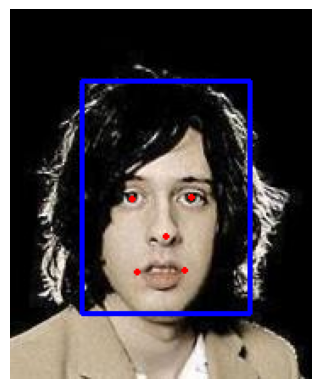

In [245]:
show_img(path, bbox, landmark)

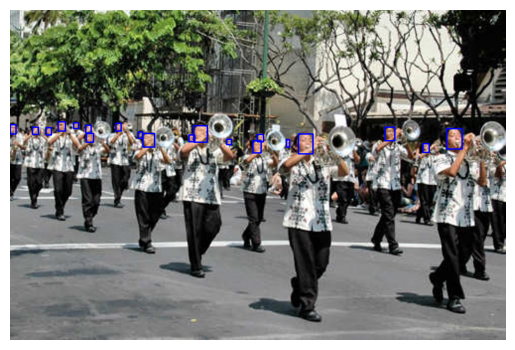

In [246]:
show_img(path2, bbox2, landmark2)

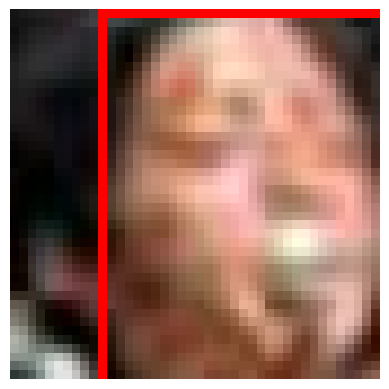

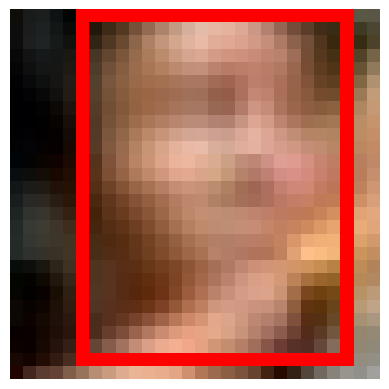

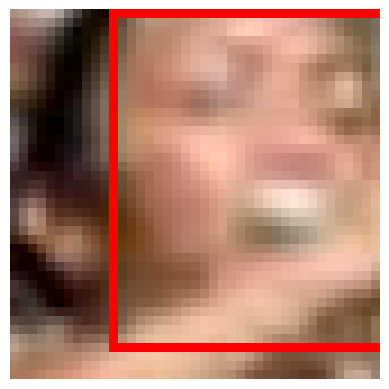

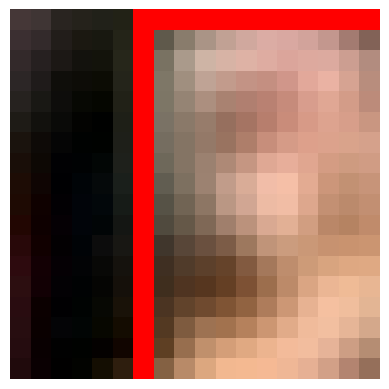

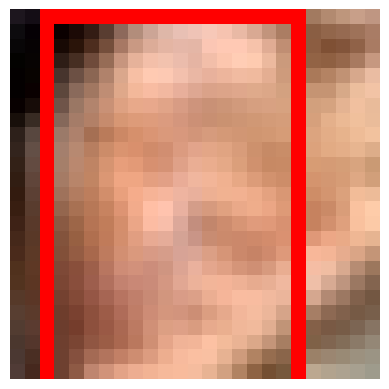

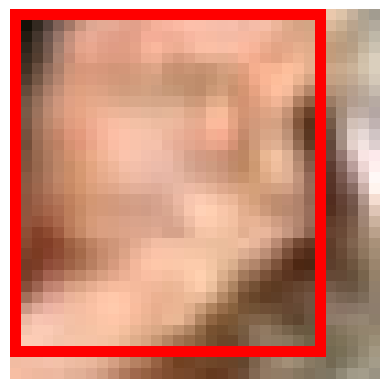

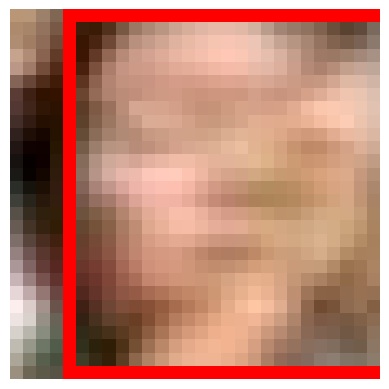

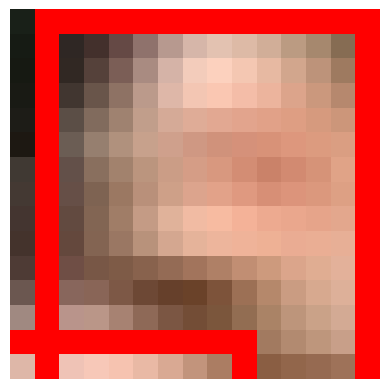

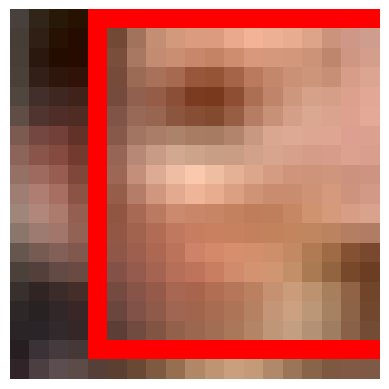

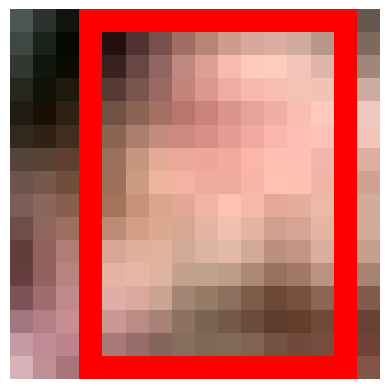

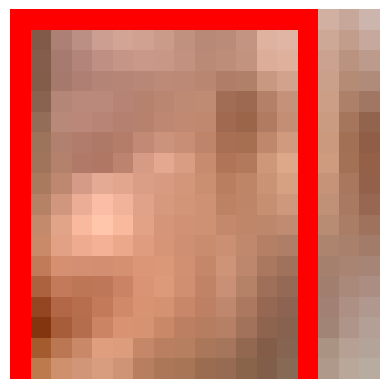

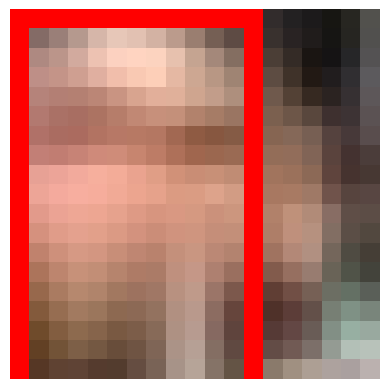

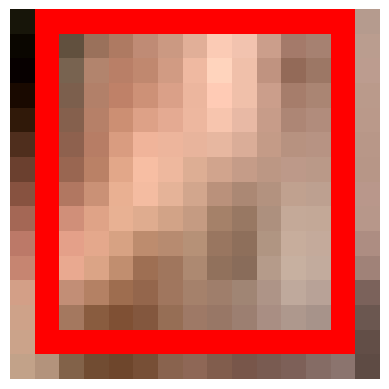

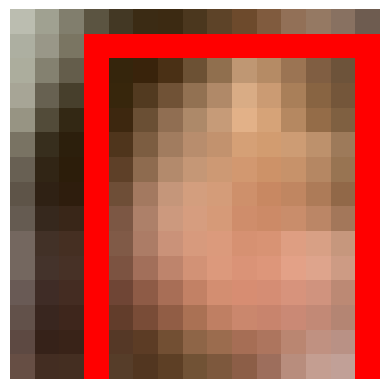

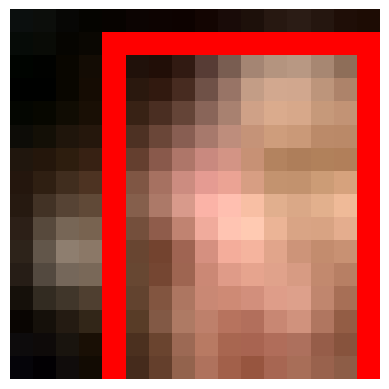

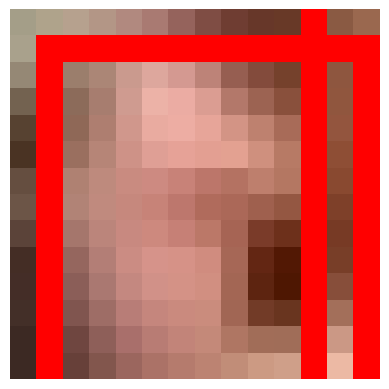

In [259]:
img = cv2.imread(path2,1)
imgs_bboxs = get_cut(img, bbox2, "p")

for img,box in imgs_bboxs:
    boxn = []
    for x in box:
        if x < 0:
            boxn.append(0)
        else:
            boxn.append(x)
            
    img = cv2.rectangle(img, (boxn[0],boxn[1]), (box[0]+box[2],box[1]+box[3]), (0, 0, 255), 1)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # 不显示坐标轴|
    plt.show()


In [228]:
def cal_iou(boxA, boxB):
    # 计算两个边界框的坐标
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # 计算交集的面积
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # 计算两个边界框的面积
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # 计算并集的面积
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # 返回计算出的IoU值
    return iou

In [258]:
def get_cut(img, bboxs, type):
    # 结果 边框
    imgs_bboxs = []
    # 从所有 标记数据中 选择 人脸边框
    for bbox in bboxs:

        # 确保 所有的已标记边框 长度 大于12像素
        if sum(bbox[2:]) < 24:
            continue
        height, width = img.shape[:2]

        # 设置三种裁剪模式 用于优化执行速度
        # p-positive 正样本模式，移动距离最小，最靠近原有边框
        # m-mixed 混合模式，移动距离中等，裁取一半原有边框
        # n-negative 负样本模式，移动距离最大，采取不相干的样本
        if type == "p":
            change_step = max(bbox[2],bbox[3])//2
        elif type == "m":
            change_step = max(bbox[2],bbox[3])*2
        else:
            change_step = height//3

        # 无限循环保险
        safe_counter = 0
        while safe_counter < 100:
            safe_counter += 1
            # 无限循环保险
            sec_safe_counter = 0
            while sec_safe_counter < 100:
                sec_safe_counter += 1

                # 先随机生成两个轴向的偏移量
                nx_shift = random.randint(0,change_step)
                ny_shift = random.randint(0,change_step)
                nx = bbox[0] + nx_shift
                ny = bbox[1] + ny_shift
                # 通过随机数 进行 正负偏移
                if random.randint(0,1):
                    nx = nx - 2*nx_shift
                if random.randint(0,1):
                    ny = ny - 2*ny_shift

                # 裁剪安全检查
                if nx>=0 and ny>=0 and nx<=width and ny<=height:
                    break
            
            if sec_safe_counter >= 100:
                break #search fail break the loop

            # 设置最大剪裁边框，三个神经网络的输入都是正方形，两边同长
            max_length = max([bbox[2],bbox[3]])
            nh = max_length
            nw = max_length

            boxA = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            boxB = [nx, ny, nw+nx, nh+ny]
            iou = cal_iou(boxA,boxB) # 计算 iou 来决策是否是我们要的样本

            # 移动原有的边框空间位置，让其作用于新的空间
            nbx = bbox[0] - nx
            nby = bbox[1] - ny
            nbw = bbox[2]
            nbh = bbox[3]

            # 通过不同的 iou 划分不同模式下要的样本
            if type == "p" and iou > 0.6:
                imgn = img[ny:ny+nh, nx:nx+nw, :]
                imgs_bboxs.append((imgn, (nbx,nby,nbw,nbh)))
                break
            if type == "n" and iou < 0.2:
                imgn = img[ny:ny+nh, nx:nx+nw, :]
                imgs_bboxs.append((imgn, (nbx,nby,nbw,nbh)))
                break
            if type == "m" and iou > 0.2 and iou < 0.55 :
                imgn = img[ny:ny+nh, nx:nx+nw, :]
                imgs_bboxs.append((imgn, (nbx,nby,nbw,nbh)))
                break
                
    return imgs_bboxs
